In [226]:
import numpy as np

In [227]:
import pandas as pd

df_X_train  = pd.read_csv('x_train.csv')
df_X_test  = pd.read_csv('x_test.csv')
df_X_test.head()

,1,-1,-1.1,-1.2,1.1,1.2,1.3,1.4,1.5,1.6,-1.3,1.7,-1.4,-1.5
0,1,1,1,1,1,1,-1,-1,-1,1,-1,1,1,1
1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1
2,-1,1,-1,-1,1,1,-1,-1,1,1,-1,1,1,1
3,1,-1,-1,-1,1,1,1,-1,-1,-1,-1,1,-1,1
4,-1,1,1,1,-1,1,1,-1,-1,-1,1,1,1,1


In [228]:
df_X_train.head()

,-1,-1.1,1,-1.2,1.1,-1.3,1.2,1.3,1.4,1.5,-1.4,1.6,-1.5,1.7
0,1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,1,-1
1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,1,1
2,1,1,1,1,-1,1,-1,-1,1,-1,1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,1,1
4,1,-1,1,-1,-1,-1,1,1,-1,1,1,-1,1,1


In [229]:
X_train_array = df_X_train.to_numpy().T
X_test_array = df_X_test.to_numpy().T
X_train_array.shape

(14, 13106)

In [230]:
df_Y_train  = pd.read_csv('y_train.csv')
df_Y_test  = pd.read_csv('y_test.csv')
df_Y_train.head()

,3
0,1
1,2
2,3
3,3
4,0


In [231]:
Y_train_array = df_Y_train.to_numpy()
Y_test_array = df_Y_test.to_numpy()

In [232]:
# in this array i need to represent 0 - [1,,0,0,0] and 1 - [0,1,0,0] 2- [0,0,1,0] 3 - [0,0,0,1]
new_Y_train_array = []
for i in Y_train_array:
    if i[0] == 0:
        new_Y_train_array.append([1,0,0,0])
    elif i[0] == 1:
        new_Y_train_array.append([0,1,0,0])
    elif i[0] == 2:
        new_Y_train_array.append([0,0,1,0])
    elif i[0] == 3:
        new_Y_train_array.append([0,0,0,1])

new_Y_train_array = np.array(new_Y_train_array).T

new_Y_test_array = []
for i in Y_test_array:
    if i[0] == 0:
        new_Y_test_array.append([1,0,0,0])
    elif i[0] == 1:
        new_Y_test_array.append([0,1,0,0])
    elif i[0] == 2:
        new_Y_test_array.append([0,0,1,0])
    elif i[0] == 3:
        new_Y_test_array.append([0,0,0,1])

new_Y_test_array = np.array(new_Y_test_array).T

## NN Implementation

In [233]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z)) 
    return A


def softmax(z):
    # Subtract the maximum value in z for numerical stability
    shift_z = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(shift_z)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

In [234]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [235]:
import numpy as np

def forward_propagation(X, parameters, activation):
    forward_cache = {}
    L = len(parameters) // 2

    # Ensure inputs are in np.float32
    forward_cache['A0'] = X.astype(np.float32)

    for l in range(1, L):
        # Matrix multiplication and addition in np.float32
        forward_cache['Z' + str(l)] = (parameters['W' + str(l)].astype(np.float32).dot(forward_cache['A' + str(l-1)]).astype(np.float32)
                                       + parameters['b' + str(l)].astype(np.float32))

        # Apply activation functions with np.float32 precision
        if activation == 'tanh':
            forward_cache['A' + str(l)] = np.tanh(forward_cache['Z' + str(l)]).astype(np.float32)
        else:
            forward_cache['A' + str(l)] = np.maximum(0, forward_cache['Z' + str(l)]).astype(np.float32)  # ReLU

    # Last layer calculation (output layer)
    forward_cache['Z' + str(L)] = (parameters['W' + str(L)].astype(np.float32).dot(forward_cache['A' + str(L-1)]).astype(np.float32)
                                   + parameters['b' + str(L)].astype(np.float32))

    # Use sigmoid or softmax for the final layer, depending on the output size
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = 1 / (1 + np.exp(-forward_cache['Z' + str(L)])).astype(np.float32)  # Sigmoid
    else:
        exp_ZL = np.exp(forward_cache['Z' + str(L)] - np.max(forward_cache['Z' + str(L)], axis=0, keepdims=True)).astype(np.float32)  # Softmax
        forward_cache['A' + str(L)] = (exp_ZL / np.sum(exp_ZL, axis=0, keepdims=True)).astype(np.float32)

    return forward_cache['A' + str(L)], forward_cache


In [236]:
import numpy as np

def compute_cost(AL, Y):
    m = Y.shape[1]
    
    # Ensure AL and Y are in np.float32
    AL = AL.astype(np.float32)
    Y = Y.astype(np.float32)

    if Y.shape[0] == 1:
        # Compute cost for binary classification
        cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)).astype(np.float32)
    else:
        # Compute cost for multiclass classification
        cost = -(1. / m) * np.sum(Y * np.log(AL)).astype(np.float32)
    
    # Ensure the cost is a scalar value
    cost = np.squeeze(cost).astype(np.float32)
    
    return cost


In [237]:
import numpy as np

def backward_propagation(AL, Y, parameters, forward_cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = AL.shape[1]
    
    # Ensure AL and Y are in np.float32
    AL = AL.astype(np.float32)
    Y = Y.astype(np.float32)
    
    # Output layer gradient
    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = (1. / m * np.dot(grads["dZ" + str(L)], forward_cache['A' + str(L-1)].T)).astype(np.float32)
    grads["db" + str(L)] = (1. / m * np.sum(grads["dZ" + str(L)], axis=1, keepdims=True)).astype(np.float32)
    
    # Hidden layers gradients
    for l in reversed(range(1, L)):
        # Cast parameters and forward_cache to np.float32
        W_next = parameters['W' + str(l+1)].astype(np.float32)
        A_l = forward_cache['A' + str(l)].astype(np.float32)
        
        if activation == 'tanh':
            grads["dZ" + str(l)] = (np.dot(W_next.T, grads["dZ" + str(l+1)]) * derivative_tanh(A_l)).astype(np.float32)
        else:
            grads["dZ" + str(l)] = (np.dot(W_next.T, grads["dZ" + str(l+1)]) * derivative_relu(A_l)).astype(np.float32)
        
        grads["dW" + str(l)] = (1. / m * np.dot(grads["dZ" + str(l)], forward_cache['A' + str(l-1)].T)).astype(np.float32)
        grads["db" + str(l)] = (1. / m * np.sum(grads["dZ" + str(l)], axis=1, keepdims=True)).astype(np.float32)

    return grads


In [238]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
    
    return np.round(np.sum((y_pred == y)/m), 2)

In [239]:
def model(X, Y, layers_dims,X_test ,y_test, learning_rate = 0.03, activation = 'relu', num_iterations = 3000 , ):

    np.random.seed(1)
    costs = []
    test_costs = []              
    
    parameters = initialize_parameters(layers_dims)
    # print("parameters", parameters)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters, activation)

        cost = compute_cost(AL, Y)
        costs.append(cost)

        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)

        # predict test data in each iteration and append cost to test_costs
        AL_test, _ = forward_propagation(X_test, parameters, activation)
        test_cost = compute_cost(AL_test, y_test)
        test_costs.append(test_cost)
        
        

       
    return parameters,grads,costs,test_costs

In [240]:
# create function to plot the cost beautifully
# choose random color for chart

import matplotlib.pyplot as plt
def plot_cost(costs, learning_rate):
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    #set random color for chart
    color = np.random.rand(3,)
    plt.plot(costs, color = color)
    plt.show()

In [241]:
lr2 = 0.1
iters2 = 25
layers_dims = [14, 100, 40, 4]


In [242]:
parameters_2 ,grads_2 , costs_2 ,test_costs2= model(X_train_array, new_Y_train_array, layers_dims,X_test_array,new_Y_test_array, learning_rate = lr2, activation = 'relu', num_iterations = iters2)

# predict accuracy on train data

train_accuracy = predict(X_train_array, new_Y_train_array, parameters_2, activation = 'relu')

# predict accuracy on test data
test_accuracy = predict(X_test_array, new_Y_test_array, parameters_2, activation = 'relu')

train_accuracy , test_accuracy



(0.32, 0.3)

In [243]:
costs_2 , test_costs2

([1.500749,
  1.4688165,
  1.4482974,
  1.4347169,
  1.425289,
  1.4183162,
  1.4128057,
  1.408198,
  1.4041654,
  1.400511,
  1.3971224,
  1.3939359,
  1.3909253,
  1.3880625,
  1.3853257,
  1.3827016,
  1.3801836,
  1.3777605,
  1.3754103,
  1.3731338,
  1.3709328,
  1.3688021,
  1.3667247,
  1.3646983,
  1.3627177],
 [1.4569192,
  1.4383508,
  1.4262415,
  1.4179261,
  1.4118339,
  1.4070158,
  1.4029331,
  1.3993019,
  1.3959705,
  1.3928562,
  1.3899233,
  1.3871505,
  1.3844937,
  1.3819277,
  1.3794583,
  1.3770863,
  1.3748009,
  1.372584,
  1.3704404,
  1.3683622,
  1.3663375,
  1.3643619,
  1.3624364,
  1.3605562,
  1.358715])

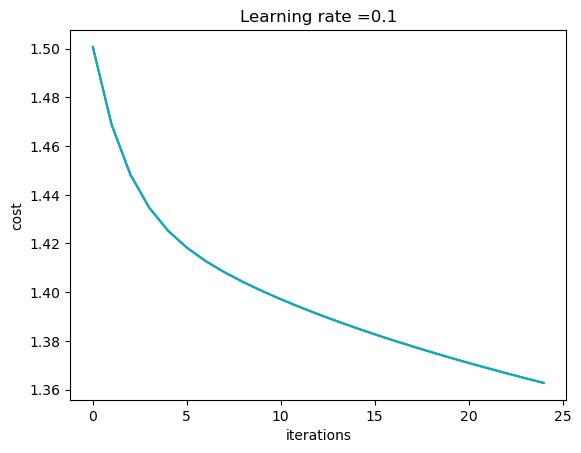

In [244]:
plot_cost(costs_2, lr2)

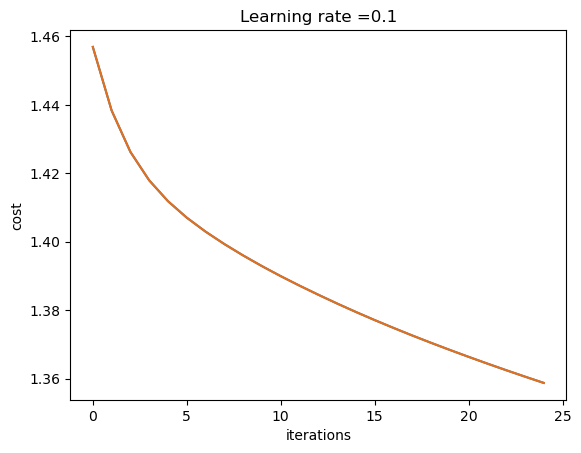

In [245]:
plot_cost(test_costs2, lr2)

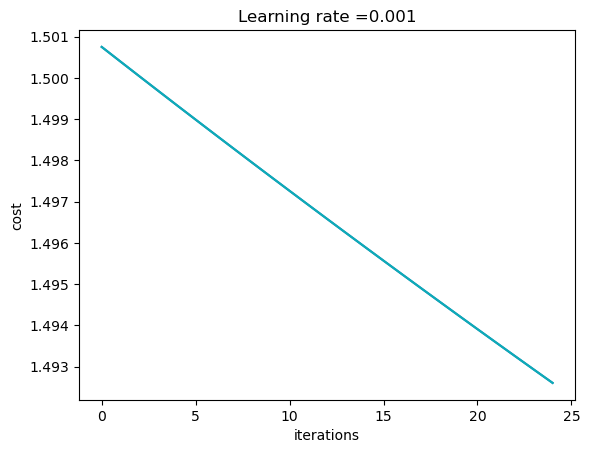

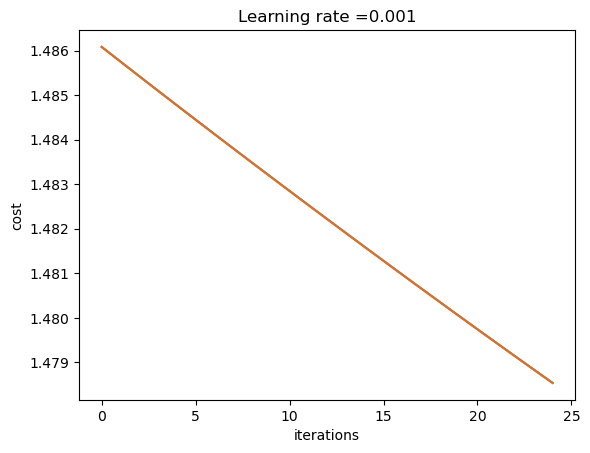

In [246]:
lr3 = 0.001
parameters_3 ,grads_3 , costs_3 ,test_costs3= model(X_train_array, new_Y_train_array, layers_dims, X_test_array,new_Y_test_array, learning_rate = lr3, activation = 'relu', num_iterations = iters2)
plot_cost(costs_3, lr3)
plot_cost(test_costs3, lr3)


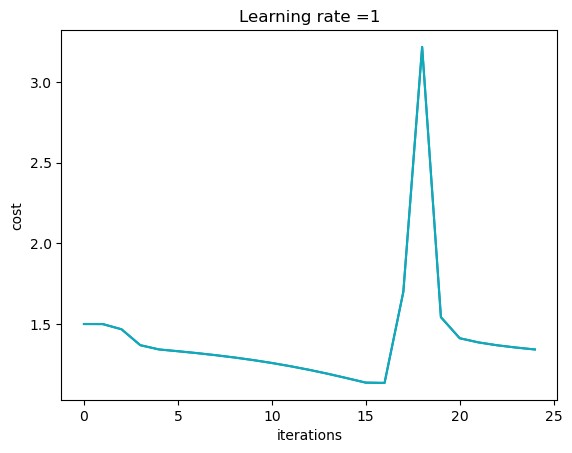

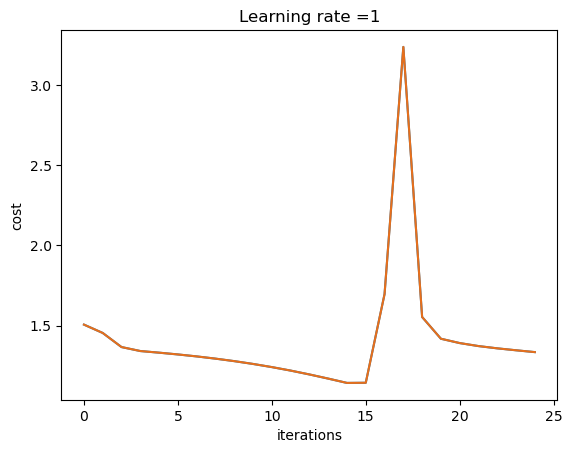

In [247]:
lr4= 1
parameters_4 ,grads_4 , costs_4 ,test_costs4= model(X_train_array, new_Y_train_array, layers_dims, X_test_array,new_Y_test_array, learning_rate = lr4, activation = 'relu', num_iterations = iters2)
plot_cost(costs_4, lr4)
plot_cost(test_costs4, lr4)

